# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from google.colab import drive
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud

# 2. Data Understanding

## 2.1 Data Loading

### 2.1.1 Mount google drive

In [2]:
drive.mount('drive')

Mounted at drive


### 2.1.2 Unzip file

In [3]:
!unzip /content/drive/MyDrive/steam_recommendation.zip

Archive:  /content/drive/MyDrive/steam_recommendation.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


### 2.1.3 Load data game

In [4]:
gamesDf = pd.read_csv('games.csv')
gamesDf

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


### 2.1.4 Load data user

In [5]:
usersDf = pd.read_csv('users.csv')
usersDf

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


### 2.1.5 Load data rekomendasi/review

In [6]:
recommendationsDf = pd.read_csv('recommendations.csv')
recommendationsDf

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.0,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.0,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.0,1044289,41154792


### 2.1.6 Load metadata game

In [7]:
gameMetaDf = pd.read_json('games_metadata.json', lines=True)
gameMetaDf

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...
50867,2296380,,[]
50868,1272080,,[]
50869,1402110,,[]
50870,2272250,Embark on a journey into the darkest nightmare...,"[Early Access, FPS, Action, Retro, First-Perso..."


### 2.1.7 menggabungkan data game dengan metadata

In [8]:
gameJoined = pd.merge(gamesDf, gameMetaDf, on='app_id')
gameJoined

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,,[Action]
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True,,[]
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True,,[]
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True,,[]
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True,Embark on a journey into the darkest nightmare...,"[Early Access, FPS, Action, Retro, First-Perso..."


## 2.2 Exploratory Data analysis

### 2.2.1 Deskripsi data game

In [9]:
gameJoined.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726788,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514164,11.507021,18.606679
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.990000,299.990000,90.000000


### 2.2.2 Deskripsi data user

In [10]:
usersDf.describe()

,user_id,products,reviews
count,1.430606e+07,1.430606e+07,1.430606e+07
mean,7.153032e+06,1.163734e+02,2.876738e+00
std,4.129805e+06,2.438515e+02,7.987421e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.576516e+06,2.300000e+01,1.000000e+00
50%,7.153032e+06,5.500000e+01,1.000000e+00
75%,1.072955e+07,1.270000e+02,3.000000e+00
max,1.430606e+07,3.221400e+04,6.045000e+03


### 2.2.3 Deskripsi data review

In [11]:
recommendationsDf.describe()

,app_id,helpful,funny,hours,user_id,review_id
count,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07
mean,6.032724e+05,3.202567e+00,1.058071e+00,1.006022e+02,7.450576e+06,2.057740e+07
std,4.729233e+05,4.693649e+01,2.867060e+01,1.761675e+02,4.010685e+06,1.188037e+07
min,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.539400e+05,0.000000e+00,0.000000e+00,7.800000e+00,4.287256e+06,1.028870e+07
50%,4.351500e+05,0.000000e+00,0.000000e+00,2.730000e+01,7.546446e+06,2.057740e+07
75%,9.331100e+05,0.000000e+00,0.000000e+00,9.920000e+01,1.096877e+07,3.086609e+07
max,2.253290e+06,3.621200e+04,2.810900e+04,1.000000e+03,1.430606e+07,4.115479e+07


### 2.2.4 Jumlah game tanpa tag

In [12]:
gameJoined[gameJoined["tags"].str.len() == 0].shape

(1244, 15)

### 2.2.5 Game dengan nama duplikat

In [13]:
gameJoined[gameJoined.title.duplicated()][['app_id','title']]

,app_id,title
6874,2023050,Lighthouse Keeper
8039,1831870,The Hotel
9917,38720,RUSH
12048,1258590,Locked Up
20768,293340,The Good Life
...,...,...
50098,2340010,Ritual
50119,2314110,Shutter
50500,2365200,Loop
50585,2239320,The Visitor


### 2.2.6 Top 10 Tag dan Banyak Tag

Total tag: 441


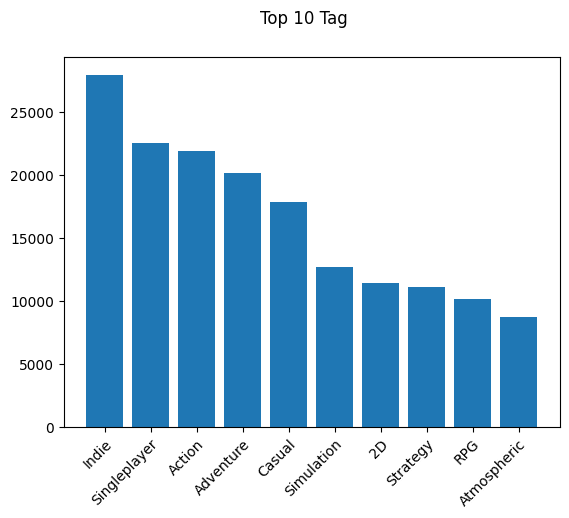

In [14]:
tags = [tag for gametag in gameMetaDf['tags'] for tag in gametag]

tagCounts = Counter(tags)
print('Total tag:',len(tagCounts))
top10 = tagCounts.most_common(10)

plt.bar([val[0] for val in top10], [val[1] for val in top10], align='center')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.suptitle('Top 10 Tag')
plt.show()

### 2.2.7 Tag Wordcloud

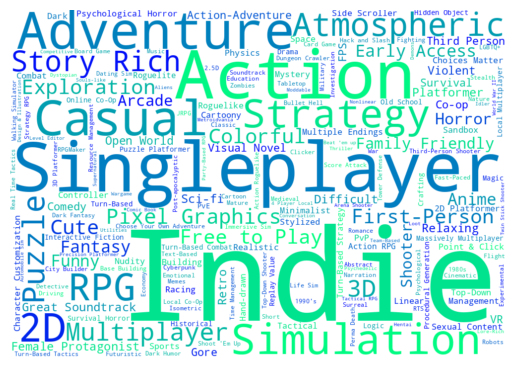

In [15]:
wc = WordCloud(background_color="white", max_font_size=256,
               random_state=0, width=1000, height=700, colormap="winter")
wc.generate_from_frequencies(tagCounts)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

### 2.2.8 Jumlah Rating

<Axes: title={'center': 'Jumlah rating pada game'}>

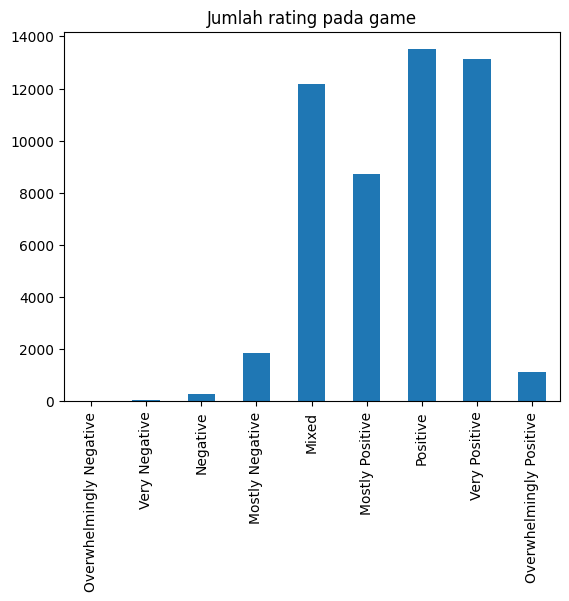

In [16]:
rateList = [
    'Overwhelmingly Negative',
    'Very Negative',
    'Negative',
    'Mostly Negative',
    'Mixed',
    'Mostly Positive',
    'Positive',
    'Very Positive',
    'Overwhelmingly Positive',
]

gameJoined['rating'].value_counts()[rateList].plot(kind='bar', title='Jumlah rating pada game')

### 2.2.9 Histogram data game

array([[<Axes: title={'center': 'positive_ratio'}>,
        <Axes: title={'center': 'price_final'}>],
       [<Axes: title={'center': 'price_original'}>,
        <Axes: title={'center': 'discount'}>]], dtype=object)

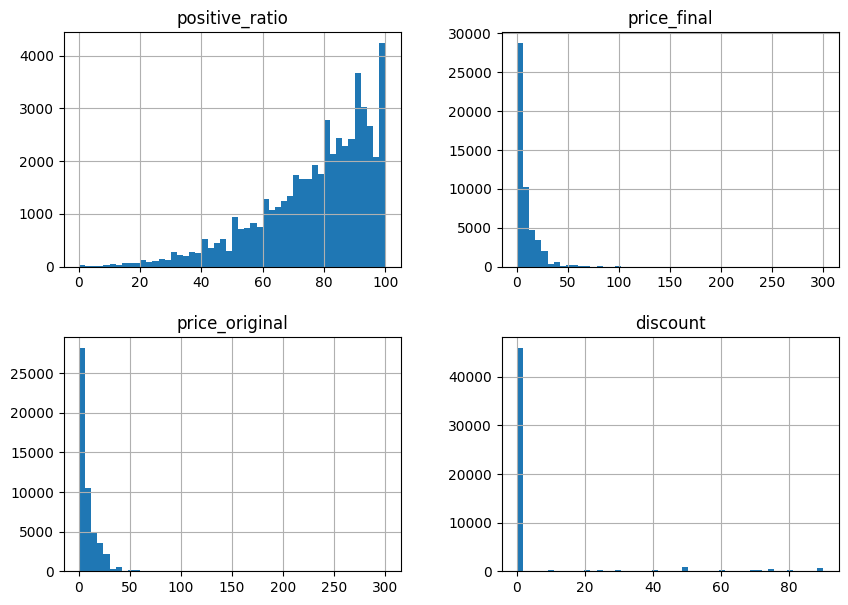

In [17]:
gameJoined.drop(columns=['app_id', 'user_reviews']).hist(bins=50, figsize=(10,7))

### 2.2.10 Histogram user-review

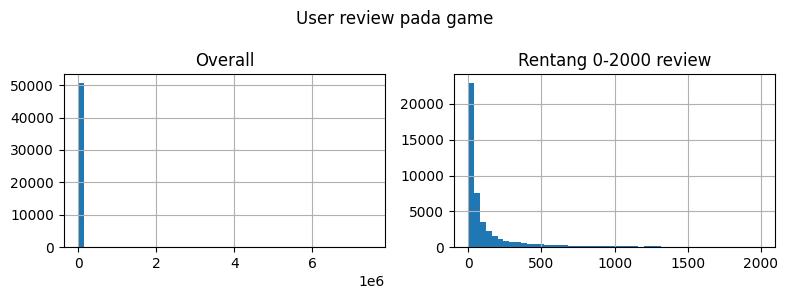

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

gameJoined['user_reviews'].hist(bins=50, ax=ax1)
ax1.set_title('Overall')

gameJoined['user_reviews'].hist(bins=50, range=[0,2000], ax=ax2)
ax2.set_title('Rentang 0-2000 review')

plt.suptitle('User review pada game')
plt.tight_layout()
plt.show()

### 2.2.11 Histogram data review

Text(0.5, 1.0, 'rentang 0-50 review')

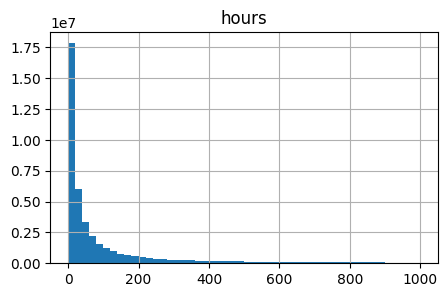

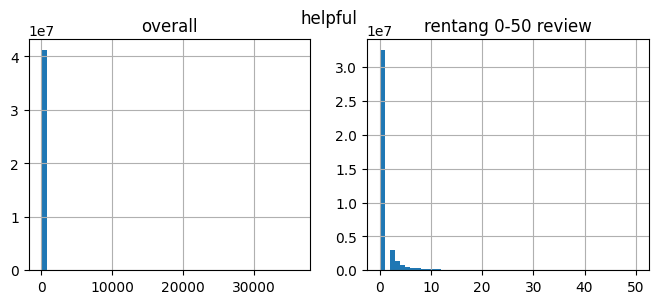

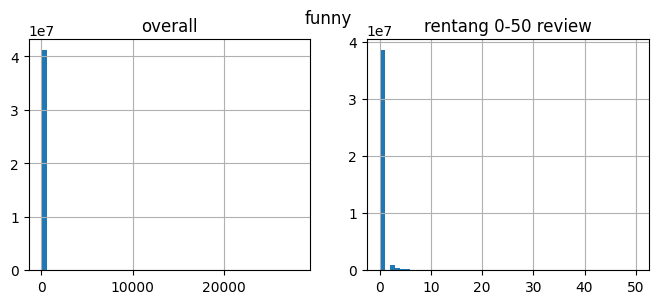

In [19]:
fig, ax = plt.subplots(figsize=(5,3))
recommendationsDf['hours'].hist(bins=50, ax=ax)
ax.set_title('hours')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
fig.suptitle('helpful')
recommendationsDf['helpful'].hist(bins=50, ax=ax1)
ax1.set_title('overall')
recommendationsDf['helpful'].hist(bins=50, range=[0,50], ax=ax2)
ax2.set_title('rentang 0-50 review')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
fig.suptitle('funny')
recommendationsDf['funny'].hist(bins=50, ax=ax1)
ax1.set_title('overall')
recommendationsDf['funny'].hist(bins=50, range=[0,50], ax=ax2)
ax2.set_title('rentang 0-50 review')

### 2.2.12 Histogram data user

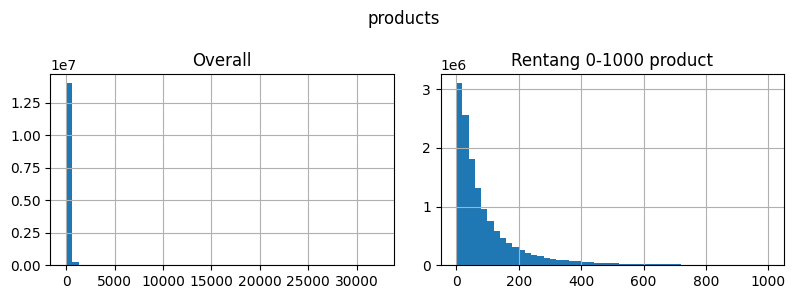

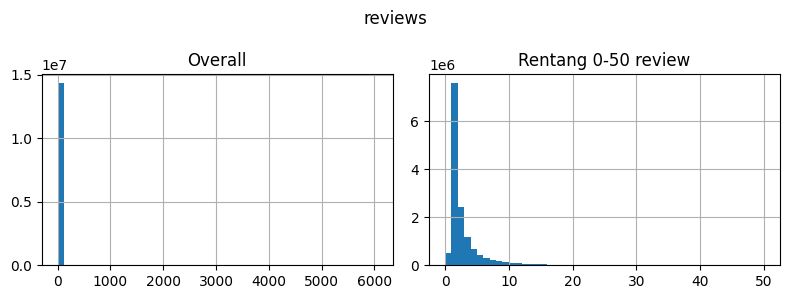

In [20]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
usersDf['products'].hist(bins=50, ax=ax[0])
usersDf['products'].hist(bins=50, range=[0,1000], ax=ax[1])
fig.suptitle('products')
ax[0].set_title('Overall')
ax[1].set_title('Rentang 0-1000 product')
plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(8,3))
usersDf['reviews'].hist(bins=50, ax=ax[0])
usersDf['reviews'].hist(bins=50, range=[0,50], ax=ax[1])
fig.suptitle('reviews')
ax[0].set_title('Overall')
ax[1].set_title('Rentang 0-50 review')
plt.tight_layout()
plt.show()

### 2.2.13 Berapa review yang merekomendasikan game yang direview

<Axes: >

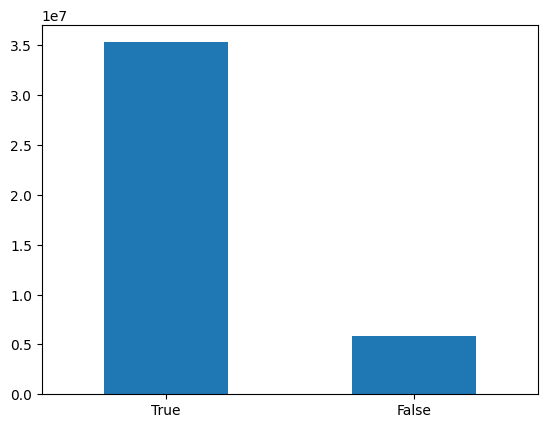

In [21]:
recommendationsDf['is_recommended'].value_counts().plot(kind='bar', rot=0)

# 3. Content-Based Filtering

## 3.1 Data preparation

### 3.1.1 Mengambil app_id, title, dan tags deari data game

In [22]:
dfContent = gameJoined[['app_id', 'title', 'tags']]

### 3.1.2 Drop game yang tidak memiliki tag

In [23]:
dfContentWithTag = dfContent[dfContent["tags"].str.len() != 0]

### 3.1.3 Feature engineering dengan TF-IDF

In [24]:
tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
dfMatrix = pd.DataFrame(
    tfidf.fit_transform(dfContentWithTag.pop('tags')).todense(),
    columns=tfidf.get_feature_names_out(),
    index=dfContentWithTag.app_id
)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 3.2 Modelling

### 3.2.1 Inisiasi model KNN

In [25]:
knnContent = NearestNeighbors(metric='cosine')

### 3.2.2 Fit model KNN dengan data matrix

In [26]:
knnContent.fit(dfMatrix)

NearestNeighbors(metric='cosine')

## 3.3 Merekomendasikan Game

### 3.3.1 Inisiasi method rekomendasi

In [27]:
def recommendGameContent(gameId, k=5):
    neighbors = knnContent.kneighbors(dfMatrix[dfMatrix.index == gameId], n_neighbors=k+1)
    gameIds = dfContentWithTag.iloc[neighbors[1][0][1:]]['app_id']

    return pd.DataFrame(
        gameIds
    ).merge(gameJoined, left_on='app_id', right_on='app_id')

### 3.3.2 Melihat game yang akan dibuat rekomendasinya

In [28]:
testid = 445980
testGame = gameJoined[gameJoined['app_id'] == testid]
testGame[['app_id','title', 'tags']]

,app_id,title,tags
47800,445980,Wizard of Legend,"[Action Roguelike, Pixel Graphics, Roguelike, ..."


### 3.3.3 Generate rekomendasi

In [29]:
recommendResult = recommendGameContent(testid)
recommendResult[['app_id','title', 'tags']]

,app_id,title,tags
0,314410,Rampage Knights,"[Co-op, Action Roguelike, Action, Beat 'em up,..."
1,1321010,Labyrinth Legend,"[Hack and Slash, Action RPG, Dungeon Crawler, ..."
2,330020,Children of Morta,"[Multiplayer, Roguelike, Hack and Slash, Actio..."
3,492410,Rogues Like Us,"[Action Roguelike, Action, Indie, Roguelite, H..."
4,1280930,Astral Ascent,"[Roguelite, Action Roguelike, Pixel Graphics, ..."


## 3.4 Evaluasi

In [30]:
def evaluate(targetId, recommendedGames):
  targetTags = gameJoined[gamesDf['app_id'] == targetId]['tags'].tolist()[0]
  # print(targetTags)

  relevant = 0
  i=1
  for recommendTags in recommendedGames['tags']:
    # print(recommendTags)
    intersect = set(targetTags).intersection(recommendTags)
    union = set(targetTags).union(recommendTags)
    jaccard =  len(intersect) / len(union)
    print("Jaccard similarity untuk game ke-"+str(i)+" :",jaccard)
    if jaccard >= 0.5:
      relevant += 1

    i+=1

  print('precision@k = '+str(relevant/len(recommendedGames)))

evaluate(445980, recommendResult)

Jaccard similarity untuk game ke-1 : 0.6666666666666666
Jaccard similarity untuk game ke-2 : 0.6666666666666666
Jaccard similarity untuk game ke-3 : 0.5384615384615384
Jaccard similarity untuk game ke-4 : 0.42857142857142855
Jaccard similarity untuk game ke-5 : 0.6
precision@k = 0.8


# 4. Collaborative Filtering

## 4.1 Data preparation

### 4.1.1 Mengambil app_id, user_id, dan is_recommended dari data review

In [31]:
dfCollab = recommendationsDf[['app_id','user_id','is_recommended']]

### 4.1.2 Drop review yang tidak merekomendasikan game

In [32]:
dfCollab = dfCollab[dfCollab['is_recommended'] == True]

### 4.1.3 Membuat user-item matrix

In [33]:
userIds = dfCollab['user_id'].unique().tolist()
gameIds = dfCollab['app_id'].unique().tolist()

userToEncode = {x:i for i,x in enumerate(userIds)}
encodeToUser = {i:x for i,x in enumerate(userIds)}
gameToEncode = {x:i for i,x in enumerate(gameIds)}
encodeToGame = {i:x for i,x in enumerate(gameIds)}

userGameMatrix = coo_matrix(
    (
        [1 for x in range(dfCollab.shape[0])],
        (dfCollab['user_id'].map(userToEncode), dfCollab['app_id'].map(gameToEncode))
    )
)

userGameMatrixCsr = userGameMatrix.tocsr()

## 4.2 Modelling

### 4.2.1 Inisiasi model K-Means

In [34]:
kmeansCollab = MiniBatchKMeans(random_state=0, n_clusters=1800)

### 4.2.2 Training model K-Means

In [35]:
kmeansCollab.fit(userGameMatrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=1800, random_state=0)

## 4.3 Merekomendasikan Game

### 4.3.1 Inisiasi method rekomendasi

In [36]:
def recommendGameCollab(userId, k=5):
    recommendedByUser = userGameMatrixCsr[userToEncode[userId]].nonzero()[1]

    clusterNumber = kmeansCollab.labels_[userToEncode[userId]]
    clusterIndeces = np.where(kmeansCollab.labels_ == clusterNumber)

    totalRecommended = np.sum(userGameMatrixCsr[clusterIndeces], axis=0).A1
    gameIndeces = np.argsort(totalRecommended)[::-1]

    gameRecommend = [game for game in gameIndeces if game not in recommendedByUser]

    gameIds = list(map(lambda x:encodeToGame[x], gameRecommend[:k]))
    return gameJoined[gameJoined['app_id'].isin(gameIds)]

### 4.3.2 Melihat game yang direview oleh user yang akan dibuat rekomendasinya

In [37]:
testid = 51580
games = dfCollab[dfCollab['user_id'] == 51580]['app_id']
gameJoined[gameJoined['app_id'].isin(games)]

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags
12797,1817190,Marvel’s Spider-Man: Miles Morales,2022-11-18,True,False,False,Very Positive,94,16625,50.00,0.00,0.0,True,,[]
47730,379720,DOOM,2016-05-12,True,False,False,Overwhelmingly Positive,95,121343,20.00,0.00,0.0,True,,[]
47925,590380,Into the Breach,2018-02-27,True,True,True,Very Positive,94,14489,14.99,14.99,0.0,True,Control powerful mechs from the future to defe...,"[Strategy, Turn-Based Strategy, Indie, Pixel G..."
48244,975370,Dwarf Fortress,2022-12-06,True,False,False,Overwhelmingly Positive,95,19665,30.00,0.00,0.0,True,,[]
48859,1649080,Two Point Campus,2022-08-09,True,True,True,Very Positive,88,2421,30.00,0.00,0.0,True,,[]


### 4.3.3 Generate rekomendasi

In [38]:
recommendResult = recommendGameCollab(51580)
recommendResult

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags
14537,546560,Half-Life: Alyx,2020-03-23,True,False,False,Overwhelmingly Positive,98,71472,60.00,0.00,0.0,True,,[]
15077,1237970,Titanfall® 2,2020-06-18,True,False,False,Very Positive,94,154419,3.00,0.00,0.0,True,,[]
15154,611500,Quake Champions,2022-08-18,True,False,False,Mostly Positive,73,36191,0.00,0.00,0.0,True,Step into the Arena. Compete against players f...,"[Arena Shooter, Hero Shooter, Early Access, FP..."
47380,440,Team Fortress 2,2007-10-10,True,True,True,Very Positive,93,985819,0.00,0.00,0.0,True,,[]
47386,2280,DOOM (1993),2007-08-03,True,False,False,Overwhelmingly Positive,96,13070,4.99,4.99,0.0,True,You’re a marine—one of Earth’s best—recently a...,"[FPS, Classic, Action, 1990's, Great Soundtrac..."


## 4.4 Evaluasi

In [39]:
silhouette_score(userGameMatrixCsr, kmeansCollab.labels_, sample_size=100000, random_state=0)

0.21968125181380824